In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from dateutil.relativedelta import relativedelta

import scipy.stats as scs
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split # разбиение данных на тренировочные и тестовые


from sklearn.preprocessing import StandardScaler # нормализация и масштабирование данных

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import cross_val_score # кроссвалидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров с кроссвалидацией

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import f1_score

import statsmodels


import gc
import glob
import os
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from numpy import percentile

# sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from tqdm import tqdm
from tensorflow.keras.models import load_model

from itertools import product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/k8s/datasets/nabout.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df_anomaly = df.copy()
df = df[['cpu_usage',	'net_usage',	'disk_usage']]
df

,cpu_usage,net_usage,disk_usage
timestamp,,,
2014-02-14 14:30:00,0.132,236906.0,43216100.0
2014-02-14 14:35:00,0.134,247200.0,863964000.0
2014-02-14 14:40:00,0.134,244932.0,128310000.0
2014-02-14 14:45:00,0.134,249894.0,0.0
2014-02-14 14:50:00,0.134,226273.0,125814000.0
...,...,...,...
2014-03-13 14:04:00,0.066,219813.0,7878250.0
2014-03-13 14:09:00,0.068,207644.0,107195000.0
2014-03-13 14:14:00,0.134,204319.0,44328600.0


In [ ]:
for column in df.columns:
    fig = px.line(df, x=df.index, y=[column], title='AWS ' + column, template = 'plotly_dark')
    fig.show()

# Autoencoder

In [ ]:
column_usage = 'cpu_usage'
StSc = StandardScaler()
StSc.fit(df[[column_usage]])

df_sc = StSc.transform(df[[column_usage]])

In [ ]:
def Random(seed_value):
    import os
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [ ]:
# Функция для обучения конкретной архитектуры модели
def arch(param, data):
    """
    Обучение конкретной архитектуры

    Parameters
    ----------
    param : list

    data : np.array
    """
    Random(0)
    input_dots = Input((1,))

    x = Dense(param[0])(input_dots)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    bottleneck = Dense(param[2], activation='linear')(x)

    x = Dense(param[1])(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[0])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(1, activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(param[3]), loss='mae', metrics=["mae"])

    model.fit(data, data,
                validation_split=0.2,
                epochs=param[5],
                batch_size=param[4],
                verbose=1,
                shuffle=False,
               )
    return model

In [ ]:
use_saved_model = False
model = model =  load_model('/content/my_model(1).h5') if use_saved_model else arch(param=(7, 6, 5, 0.0001, 20, 100), data=df_sc)

Epoch 1/100
311/311 [==============================] - 7s 5ms/step - loss: 0.6320 - mae: 0.6320 - val_loss: 0.6116 - val_mae: 0.6116
Epoch 2/100
311/311 [==============================] - 1s 3ms/step - loss: 0.5530 - mae: 0.5530 - val_loss: 0.6238 - val_mae: 0.6238
Epoch 3/100
311/311 [==============================] - 1s 3ms/step - loss: 0.4902 - mae: 0.4902 - val_loss: 0.5963 - val_mae: 0.5963
Epoch 4/100
311/311 [==============================] - 1s 4ms/step - loss: 0.4393 - mae: 0.4393 - val_loss: 0.6082 - val_mae: 0.6082
Epoch 5/100
311/311 [==============================] - 1s 4ms/step - loss: 0.3824 - mae: 0.3824 - val_loss: 0.6343 - val_mae: 0.6343
Epoch 6/100
311/311 [==============================] - 1s 3ms/step - loss: 0.3160 - mae: 0.3160 - val_loss: 0.6404 - val_mae: 0.6404
Epoch 7/100
311/311 [==============================] - 1s 3ms/step - loss: 0.2749 - mae: 0.2749 - val_loss: 0.6689 - val_mae: 0.6689
Epoch 8/100
311/311 [==============================] - 1s 3ms/step - 

In [ ]:
for i in range(df_sc.shape[1]):
    fig = px.line(df,
                  x=df.index,
                  y=[StSc.inverse_transform(df_sc)[:, i],
                     StSc.inverse_transform(model.predict(df_sc))[:, i]],
                  title='AWS ' + column,
                  template = 'plotly_dark')
    fig.show()

243/243 [==============================] - 1s 2ms/step


In [ ]:
mean_absolute_error(df_sc, model.predict(df_sc))

243/243 [==============================] - 0s 2ms/step


0.5178183068503747

In [ ]:
pred_residuals = df_sc - model.predict(df_sc)
UCL = pd.DataFrame(pred_residuals).abs().sum(axis=1).quantile(0.95)

fig = px.line(df,
              x=df.index,
              y=[pred_residuals[:, 0]],
              title='График разностей сигналов',
              template = 'plotly_dark')
fig.show()

243/243 [==============================] - 0s 2ms/step


In [ ]:
fig = px.line(df,
              x=df.index,
              y=[pd.DataFrame(pred_residuals, index=df.index).abs().sum(axis=1).values, np.full(shape=len(pred_residuals),fill_value=UCL,dtype=np.float64 )],
              title='График разностей сигналов',
              template = 'plotly_dark')
fig.show()

In [ ]:
dfx = df.copy()
dfx['is_outlier'] = pd.DataFrame(pred_residuals, index=df.index).abs().sum(axis=1) > UCL
dfx["outlier"] = dfx["is_outlier"].astype(int)
dfx

,cpu_usage,net_usage,disk_usage,is_outlier,outlier
timestamp,,,,,
2014-02-14 14:30:00,0.132,236906.0,43216100.0,False,0
2014-02-14 14:35:00,0.134,247200.0,863964000.0,False,0
2014-02-14 14:40:00,0.134,244932.0,128310000.0,False,0
2014-02-14 14:45:00,0.134,249894.0,0.0,False,0
2014-02-14 14:50:00,0.134,226273.0,125814000.0,False,0
...,...,...,...,...,...
2014-03-13 14:04:00,0.066,219813.0,7878250.0,False,0
2014-03-13 14:09:00,0.068,207644.0,107195000.0,False,0
2014-03-13 14:14:00,0.134,204319.0,44328600.0,False,0


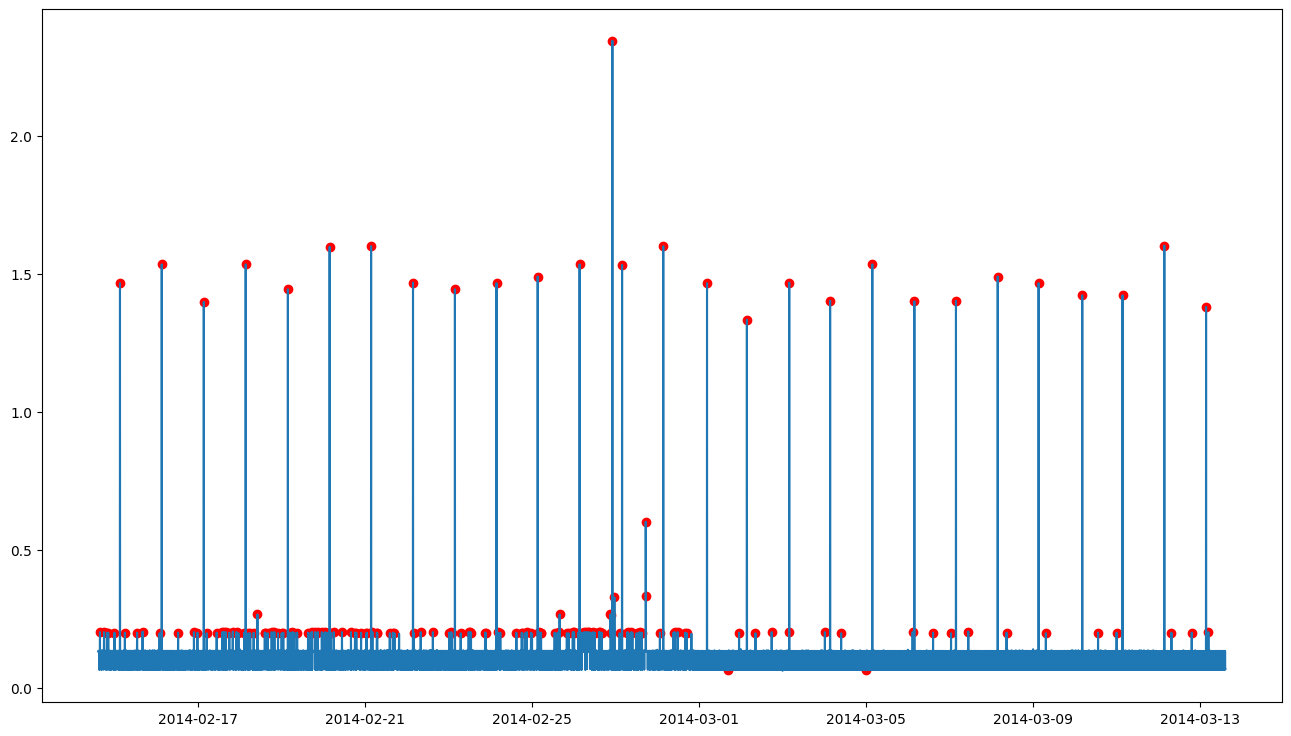

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
a = dfx.loc[dfx.outlier == 1, [column_usage]]

ax.plot(dfx.index, dfx[column_usage])
ax.scatter(a.index, a[column_usage], color='red')
plt.show()

In [ ]:
# Define colors for anomalies and non-anomalies
y_pred = dfx['outlier']
X = df.copy()
colors = ['green' if a == 0 else 'red' for a in y_pred]

# Create a scatter plot of the data with anomalies highlighted in red
fig = go.Figure(data=go.Scatter(x=dfx.index, y=dfx[column_usage],
                                 mode='markers', marker=dict(color=colors, size=3)))

# Set the title and axis labels for the plot
fig.update_layout(title=dict(text='LOF Anomaly prediction', x=0.5),
                  yaxis_title='Value',
                  xaxis_title='Timestamp')

# Show the plot
fig.show()

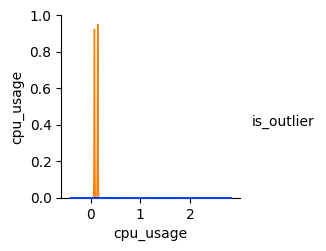

In [ ]:
sns.pairplot(data=dfx, vars = df[[column_usage]],
             hue='is_outlier', hue_order=[1, 0],
             markers=['*', 'o'],  palette='bright');

# Metrics


In [ ]:
y_pred = y_pred == 0
dfx['name'] = y_pred
y_pred

timestamp
2014-02-14 14:30:00    True
2014-02-14 14:35:00    True
2014-02-14 14:40:00    True
2014-02-14 14:45:00    True
2014-02-14 14:50:00    True
                       ... 
2014-03-13 14:04:00    True
2014-03-13 14:09:00    True
2014-03-13 14:14:00    True
2014-03-13 14:19:00    True
2014-03-13 14:24:00    True
Name: outlier, Length: 7775, dtype: bool

In [ ]:
p_values = {}
p_stats_ = {}
percent = {}
silhoutte = {}
calinski_harabasz = {}
davies_bouldin = {}

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

cols_in = [column_usage]

In [ ]:
dfx['name'].value_counts()

True     7584
False     191
Name: name, dtype: int64

In [ ]:
#percent anomaly
dist = dfx['name'].value_counts(normalize=True)
print(dist)
percent['name'] = dist.loc[True]

True     0.975434
False    0.024566
Name: name, dtype: float64


In [ ]:
#silhouette conficient samples non-anomaly
labels = [1 if i == True else 2 for i in dfx['name']]
dfx['silhouette_zcore_'] = silhouette_samples(df[[column_usage]], labels)
silhoutte['name'] = dfx[dfx['name']]['silhouette_zcore_'].mean()

In [ ]:
#ks coeficient
normal = dfx.loc[dfx['name'] == False, [column_usage]]
anomaly = dfx.loc[dfx['name'] == True, [column_usage]]
for col_in in tqdm(cols_in):
  if len(normal)>0 and len(anomaly)>0:
    stats_, pvalue = stats.kstest(normal[col_in], anomaly[col_in])
    p_values[col_in+'_'] = pvalue
    p_stats_[col_in+'_'] = stats_

100%|██████████| 1/1 [00:00<00:00, 56.99it/s]


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(df[[column_usage]], labels)
calinski_harabasz['name'] = round(ch_index, 3)
print("Calinski-Harabasz Index:", round(ch_index, 3))

Calinski-Harabasz Index: 2501.637


In [ ]:
from sklearn.metrics import davies_bouldin_score

dbi = davies_bouldin_score(df[[column_usage]], labels)
davies_bouldin['name'] = round(dbi, 3)
print("Davies-Bouldin Index:", round(dbi, 3))

Davies-Bouldin Index: 1.228


pvalue
  svm_algorithm         pvalue
0    cpu_usage_  1.178129e-318
{'cpu_usage_': 1.17813e-318}


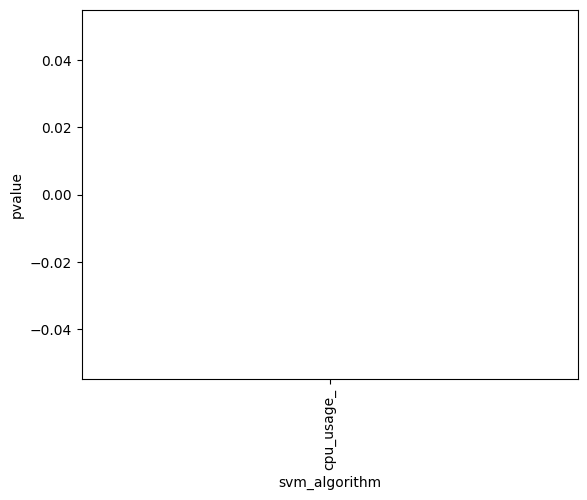

statistics
  svm_algorithm  statistics
0    cpu_usage_    0.989529
{'cpu_usage_': 0.9895287958115183}


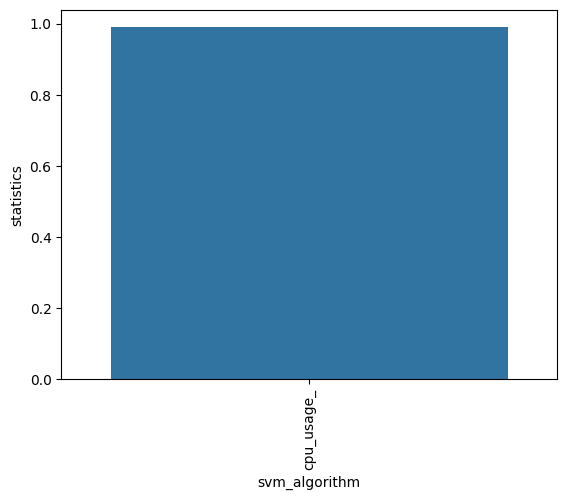

percent
  svm_algorithm   percent
0          name  0.975434
{'name': 0.9754340836012861}


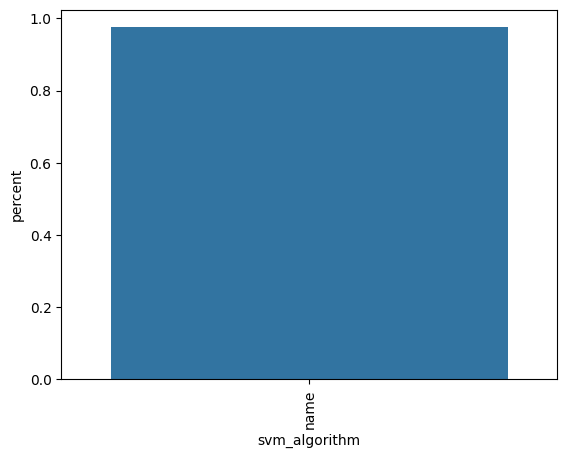

silhoutte
  svm_algorithm  silhoutte
0          name   0.883668
{'name': 0.8836678780998409}


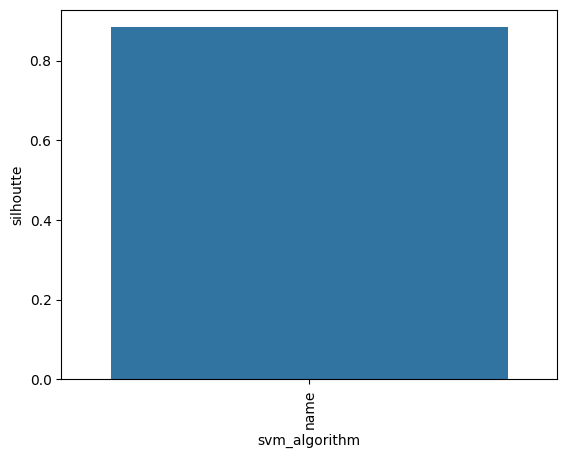

calinski_harabasz
  svm_algorithm  calinski_harabasz
0          name           2501.637
{'name': 2501.637}


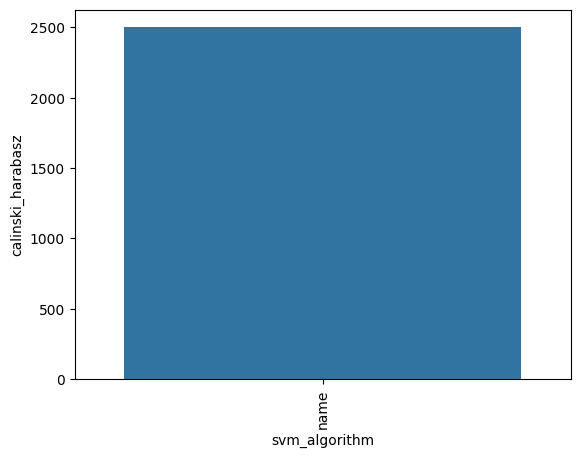

davies_bouldin
  svm_algorithm  davies_bouldin
0          name           1.228
{'name': 1.228}


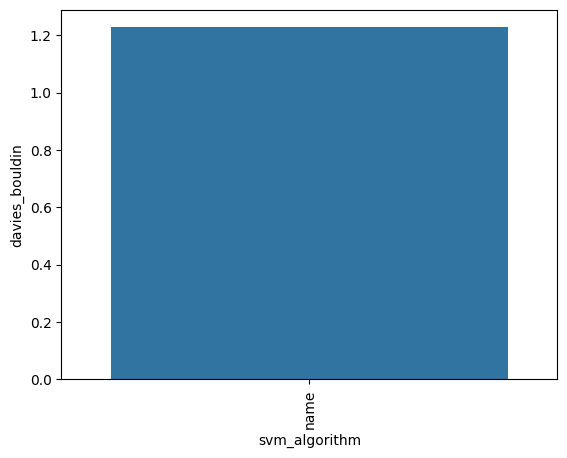

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name)
    df_values =  pd.DataFrame([dictionary])
    df_values = df_values.T
    df_values.reset_index(inplace=True)
    df_values.columns = ['svm_algorithm', name]
    print(df_values)
    print(dictionary)

    sns.barplot(data=df_values, x='svm_algorithm', y=name)
    plt.xticks(df_values.index, df_values['svm_algorithm'].values, rotation=90)
    plt.show()

In [ ]:
for name, dictionary in {'pvalue': p_values, 'statistics': p_stats_, 'percent': percent, 'silhoutte':silhoutte, 'calinski_harabasz': calinski_harabasz, 'davies_bouldin': davies_bouldin}.items():
    print(name + ': ' + str(np.array(list(dictionary.values())).mean()))

pvalue: 1.17813e-318
statistics: 0.9895287958115183
percent: 0.9754340836012861
silhoutte: 0.8836678780998409
calinski_harabasz: 2501.637
davies_bouldin: 1.228


In [ ]:
svm_df = pd.DataFrame()
svm_df['anomaly']  = [1 if i==True else 0 for i in df_anomaly.anomaly]

svm_f1 = f1_score(dfx['outlier'], svm_df['anomaly'])
print(f'One Class SVM F1 Score : {round(svm_f1 * 100,2)}%')

One Class SVM F1 Score : 14.76%


# Save Model

In [ ]:
 model.save('/content/drive/MyDrive/Colab Notebooks/k8s/models/model_autoencoder_nab.h5')
